In [131]:
import pandas as pd
import numpy as np
import os
import io
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
%matplotlib inline
from IPython.display import display

In [132]:
bdf = pd.read_csv("dataset/brand_keyword_cnt.csv")
idf = pd.read_csv("dataset/product_info.csv")
sdf = pd.read_csv("dataset/sales.csv")
tdf = pd.read_csv("dataset/new_train_3.csv")

## Feature Engineering

### Brand 인지도/충성도 : 월별 판매량을 기반으로 브랜드의 충성도를 정의한다

- Approach1: 월별 평균 판매량이 높을수록 브랜드의 충성도는 높을 것이다.
    - 충성도 측정 방법: 브랜드별 월별 판매량 및 평균 판매량 계산 후 정규화 -> 값이 높을수록 충성도가 높은 브랜드임을 가정


- Approach2: 월별 평균 판매량이 높고 일정할수록 브랜드의 충성도는 높을 것이다.
    - 충성도 측정 방법: 평균 월별 판매량과 CV (Coefficient of Variation) 기반으로 각각 가중치 적용 후 weighted 평균 계산 -> 값이 높을수록 충성도가 높은 브랜드임을 가정

In [133]:
# 브랜드별 일별 판매량
df_train = tdf.copy().iloc[:, 5:]
df_train = df_train.groupby('브랜드').sum().reset_index().transpose()
df_train.columns = df_train.loc['브랜드']
df_train.drop(index='브랜드', inplace=True)
df_train = df_train.reset_index().rename(columns={'index':'Date'})
df_train.Date = pd.to_datetime(df_train.Date)

# 브랜드별 월별 판매량
monthly_sales = df_train.groupby([df_train.Date.dt.year, df_train.Date.dt.month]).sum()

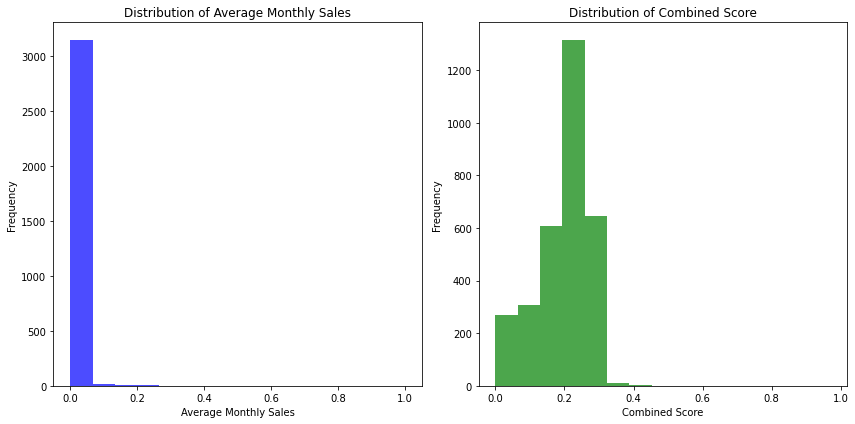

In [134]:
class brand_popularity:
    def __init__(self, df: pd.DataFrame, w1, w2, target_df: pd.DataFrame):
        '''
        df: 브랜드별 월별 판매량이 산출된 df,
        w1: 월별 판매량에 적용할 가중치
        w2: 월별 판매량의 일정함(표준편차)에 적용할 가중치
        target_df: 계산된 feature를 mapping할 df
        '''
        self.df =df
        self.w1 = w1
        self.w2 = w2
        self.target_df = target_df

    def sales_based_popularity(self):
        '''
        브랜드별 월별 평균 판매량을 활용한 충성도 점수
        '''
        average_monthly_sales = self.df.mean()
        normalized_popularity = average_monthly_sales / average_monthly_sales.max()
        return normalized_popularity
    
    def mixed_based_popularity(self):
        '''
        월별 판매량과 판매량의 표준편차를 활용한 충성도 점수
        '''
        average_monthly_sales = self.df.mean()
        normalized_popularity = average_monthly_sales / average_monthly_sales.max()
        cv = self.df.std() / self.df.mean()
        normalized_cv = cv / cv.max()
        
        combined_score = (self.w1 * normalized_popularity) + (self.w2 * (1 - normalized_cv))
        return combined_score
    
    def viz_distributions(self, score1, score2):
        fig, axes = plt.subplots(1, 2, figsize=(12,6))
        
        axes[0].hist(score1, bins=15, color='blue', alpha=0.7) 
        axes[0].set_title('Distribution of Average Monthly Sales')
        axes[0].set_xlabel('Average Monthly Sales')
        axes[0].set_ylabel('Frequency')

        axes[1].hist(score2, bins=15, color='green', alpha=0.7)
        axes[1].set_title('Distribution of Combined Score')
        axes[1].set_xlabel('Combined Score')
        axes[1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()
    
    def map_feature(self, *features: list):
        '''
        feature를 원본 train 데이터에 맵핑합니다
        '''
        for i in range(len(features)):
            feature_dict = dict(zip(features[i].index, features[i].values))
            self.target_df['popularity'+str(i+1)] = self.target_df.브랜드.map(feature_dict)
        

get_popularity = brand_popularity(monthly_sales, 0.7, 0.3, tdf)
popularity1 = get_popularity.sales_based_popularity()
popularity2 = get_popularity.mixed_based_popularity()
get_popularity.viz_distributions(popularity1, popularity2)

In [135]:
get_popularity.map_feature(popularity1, popularity2)

In [136]:
# move columns
col_data = tdf.pop('popularity1')
tdf.insert(6, 'popularity1', col_data)
col_data2= tdf.pop('popularity2')
tdf.insert(7, 'popularity2', col_data2)

In [138]:
tdf.head()

,ID,제품,대분류,중분류,소분류,브랜드,popularity1,popularity2,2022-01-01,2022-01-02,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0.000027,0.206888,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0.000222,0.220643,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0.000222,0.220643,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0.000222,0.220643,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0.001179,0.247284,0,0,...,0,0,0,0,0,0,0,0,0,0
